# Example shape parameterisation

In [1]:
import re

import numpy as np
import dicom

import matplotlib.pyplot as plt
%matplotlib inline

from electroninserts import (
    parameterise_single_insert, display_parameterisation)

print("All modules and functions successfully imported.")

All modules and functions successfully imported.


In [2]:
# !pip install --upgrade version_information
# %load_ext version_information
# %version_information dicom, electroninserts, re, numpy, matplotlib, version_information

Requirement already up-to-date: version_information in c:\users\sbiggs\appdata\local\continuum\anaconda3\envs\electroninserts\lib\site-packages


Software versions
Python 3.5.2 64bit [MSC v.1900 64 bit (AMD64)]
IPython 5.0.0
OS Windows 7 6.1.7601 SP1
dicom 0.9.9
electroninserts 0.1.0
re 2.2.1
numpy 1.11.1
matplotlib 1.5.1
version_information 1.0.3
Fri Aug 05 15:04:23 2016 AUS Eastern Standard Time

## Parameterising shapes

Three options to parameterise shapes are given below; from raw coordinates, from an RT-DICOM file, or from a Monaco&reg; 5.10 `tel.1` file.

There is also a placeholder for importing directly from Eclipse&trade;. Please [let me know](mailto:mail@simonbiggs.net)  if someone with access to Eclipse&trade; achieves this.

### From coordinates

Width = 6.53 cm
Length = 10.99 cm


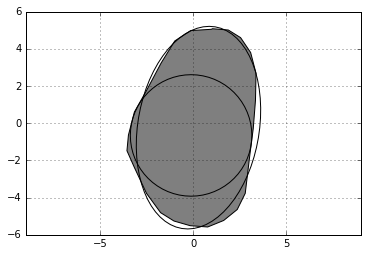

In [3]:
x = [0.99, -0.14, -1.0, -1.73, -2.56, -3.17, -3.49, -3.57, -3.17, -2.52, -1.76,
    -1.04, -0.17, 0.77, 1.63, 2.36, 2.79, 2.91, 3.04, 3.22, 3.34, 3.37, 3.08, 2.54,
    1.88, 1.02, 0.99]
y = [5.05, 4.98, 4.42, 3.24, 1.68, 0.6, -0.64, -1.48, -2.38, -3.77, -4.81,
    -5.26, -5.51, -5.58, -5.23, -4.64, -3.77, -2.77, -1.68, -0.29, 1.23, 2.68, 3.8,
    4.6, 5.01, 5.08, 5.05]

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm\nLength = {1:0.2f} cm".format(width, length))

display_parameterisation(x, y, width, length, poi)

### From RT-DICOM

If you are using the online version of this notebook you will likely want to deidentify your dicom files. http://www.dicompyler.com/ can be used to do this however I am not in a position to guarantee it will do this adequately. You need to check this yourself.

To upload the dicom file go to [notebook home](../tree) and click the "upload button" located at the top right of the dashboard.

Applicator = 10X10 (identifier name)
Energy = 12.0 (nominal)
SSD = 1001.0 (dicom units)

Width = 4.11 cm
Length = 9.52 cm


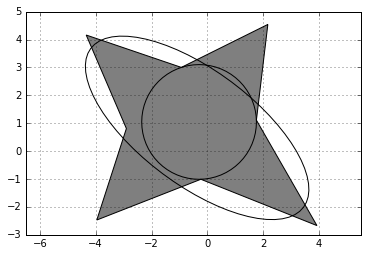

In [4]:
# Change this name to match the dicom file located in the same directory
# as this notebook.
dicom_filename = "example_dicom_file.dcm"  

dcm = dicom.read_file(dicom_filename, force=True)
applicator_string = dcm.BeamSequence[0].ApplicatorSequence[0].ApplicatorID
energy_string = dcm.BeamSequence[0].ControlPointSequence[0].NominalBeamEnergy
ssd_string = dcm.BeamSequence[0].ControlPointSequence[0].SourceToSurfaceDistance

print("Applicator = {} (identifier name)".format(applicator_string))
print("Energy = {} (nominal)".format(energy_string))
print("SSD = {} (dicom units)\n".format(ssd_string))

block_data = np.array(dcm.BeamSequence[0].BlockSequence[0].BlockData)
x = np.array(block_data[0::2]).astype(float)/10
y = np.array(block_data[1::2]).astype(float)/10

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm".format(width))
print("Length = {0:0.2f} cm".format(length))

display_parameterisation(x, y, width, length, poi)

### Directly from Monaco&reg; 5.10 server

The following code is an example of what can be used to automatically pull and parameterise shapes from the server based off of patient ID. For use in other centres it will need adjustment.

In [5]:
# patientID = '00000'.zfill(6)
# string_search_pattern = r'\\MONACODA\FocalData\YOURDIRECTORYHERE\1~Clinical\*{}\plan\*\*tel.1'.format(patientID)
# string_search_pattern

In [ ]:
# filepath_list = glob(string_search_pattern)
# filepath_list

In [6]:
telfilepath = "example_monaco510_telfile"
electronmodel_regex = "YourMachineName - \d+MeV"  # \d+ stands for any positive integer

with open(telfilepath, "r") as file:
    telfilecontents = np.array(file.read().splitlines())

electronmodel_index = []
for i, item in enumerate(telfilecontents):
    if re.search(electronmodel_regex, item):
        electronmodel_index += [i]

print("Located applicator and energy strings for plans within telfile:")
applicator_tel_string = [
    telfilecontents[i+12]  # applicator string is located 12 lines below electron model name
    for i in electronmodel_index]
print(applicator_tel_string)

energy_tel_string = [
    telfilecontents[i]
    for i in electronmodel_index]
print(energy_tel_string)

Located applicator and energy strings for plans within telfile:
['14X14']
['YourMachineName - 15MeV']


Applicator = 14X14
Energy = YourMachineName - 15MeV

Width = 8.76 cm
Length = 14.00 cm


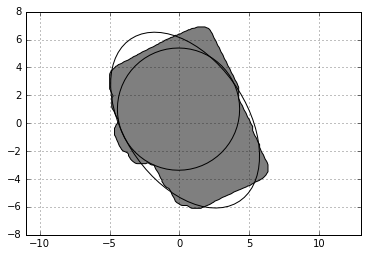

In [7]:
for i, index in enumerate(electronmodel_index):
    print("Applicator = {}".format(applicator_tel_string[i]))
    print("Energy = {}\n".format(energy_tel_string[i]))
    
    insert_inital_range = telfilecontents[
        index + 51::]  # coords start 51 lines after electron model name
    insert_stop = np.where(
        insert_inital_range=='0')[0][0]  # coords stop right before a line containing 0
    
    insert_coords_string = insert_inital_range[:insert_stop]
    insert_coords = np.fromstring(','.join(insert_coords_string), sep=',')
    x = insert_coords[0::2]/10
    y = insert_coords[1::2]/10
    
    width, length, poi = parameterise_single_insert(x, y)
    print("Width = {0:0.2f} cm".format(width))
    print("Length = {0:0.2f} cm".format(length))
    display_parameterisation(x, y, width, length, poi)

### Direct from Eclipse&trade; server

*Not yet implimented. If someone achieves this please contact me at [mail@simonbiggs.net](mailto:mail@simonbiggs.net) or create a pull request over at https://github.com/SimonBiggs/electroninserts_bundle*

## Copyright information
Copyright &#169; 2016  Simon Biggs

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.